In [185]:
#!/usr/bin/python

# Import required modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
from sklearn.svm import SVC
from sklearn.preprocessing import scale

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

# Function Definitions

In [186]:
def tabulate(predicted, true):
    """
        Tabulate the prediction accuracy of a classification,
        returning a matrix, e.g.,
        [[IZA predicted as IZA, IZA predicted as DEEM],
         [DEEM predicted as IZA, DEEM predicted as DEEM]]
         
         ---Arguments---
         predicted: predicted labels
         true: true labels
    """
    if len(predicted) != len(true):
        print 'Label vectors must be same size!'
        return
    
    # Get unique categories
    names = np.unique(np.concatenate((predicted, true)))
    n_classes = names.size
    
    # Build (mis)classification matrix
    m = np.zeros((n_classes, n_classes))
    n = len(predicted)
    
    # (TODO: generalize this to more than 2
    # classes of arbitrary labels)
    # Build (mis)classification matrix
    for p, t in zip(predicted, true):
        if p == 'IZA' and t == 'IZA':
            m[0, 0] += 1
        elif p == 'DEEM' and t == 'DEEM':
            m[1, 1] += 1
        elif p == 'IZA' and t == 'DEEM':
            m[1, 0] += 1
        elif p == 'DEEM' and t == 'IZA':
            m[0, 1] += 1
    m /= n
    return n, m

def rand_idxs(n_IZA, n_DEEM, n_train, n_test):
    """
        Randomly select indices for testing and training
        
        ---Arguments---
        n_IZA: number of IZA samples
        n_DEEM: number of DEEM samples
        n_train: desired number of training structures
        n_test: desired number of test structures
    """
    
    # Indices correspond to size of data
    IZA_idxs = np.arange(0, n_IZA)
    DEEM_idxs = np.arange(0, n_DEEM)

    # Randomize the indices
    np.random.shuffle(IZA_idxs)
    np.random.shuffle(DEEM_idxs)

    # Select training and test sets from the
    # randomized indices.
    # Assume IZA is the 'limiting case', i.e.,
    # has fewer environments
    IZA_train = IZA_idxs[0:n_train]
    IZA_test = IZA_idxs[n_train:n_train+n_test]

    DEEM_train = DEEM_idxs[0:n_train]
    DEEM_test = DEEM_idxs[n_train:n_train+n_test]
    #DEEM_test = DEEM_idxs[n_train:]

    # An extra array of shuffled indices
    # that internally shuffle the train and test
    # sets after concatenation
    shuffle_train_idxs = np.arange(0, 2*n_train)
    shuffle_test_idxs = np.arange(0, 2*n_test)
    #shuffle_test_idxs = np.arange(0, n_DEEM-n_train+n_test)

    np.random.shuffle(shuffle_train_idxs)
    np.random.shuffle(shuffle_test_idxs)
    
    return IZA_train, IZA_test, \
        DEEM_train, DEEM_test, \
        shuffle_train_idxs, shuffle_test_idxs

def fps_unique(fps_file, prec=12, plot=False):
    """
        Takes a file with columns (indices, distances)
        from an FPS calculation and subselects
        based on the distance precision
        
        ---Arguments---
        fps_file: file from an FPS calculation with indices and distances
        prec: decimal precision; if an index corresponds to a distance of zero
              after rounding to prec decimal places, the environment
              is considered nonunique
        plot: make a semilog plot of the distances
    """
    
    # Load FPS data
    idxs, fps_distances = np.loadtxt(fps_file, unpack=True)
    
    # Number of nonzero distances
    n_nonzero = np.shape(fps_distances[fps_distances.round(prec) > 0])[0]
    
    print 'Unique points with prec = %d: %d' % (prec, n_nonzero)
    
    # Indices of environments with nonzero corresponding distances
    idxs = idxs[fps_distances.round(prec) > 0].astype(np.int)
    fps_distances = fps_distances[fps_distances.round(prec) > 0]
    
    # Optional plotting
    if plot is True:
        fig = plt.figure(figsize=(3.5, 3.5))
        axs = fig.add_subplot(1, 1, 1)
        axs.semilogy(np.arange(0, fps_distances.shape[0]), fps_distances)
        axs.axvline(n_nonzero, color='r', linestyle='--')
        plt.show()
        
    return idxs#, fps_distances

def iza_deem_unique(deem, iza, metric='euclidean', prec=12):
    """
        Takes IZA and DEEM environments and removes the DEEM
        environments that are identical (to `prec` decimal places)
        to an IZA environment
        
        ---Arguments---
        iza: iza data where environments are rows and features are columns
        deem: deem data where environments are rows and features are columns
        metric: distance metric
        prec: decimal place precision for the distance comparison
    """
    
    # Compute distances between environments
    d = cdist(deem, iza)
    
    # Return only environments that have nonzero
    # corresponding distances
    idxs = np.any(d.round(prec) > 0.0, axis=1)
    return deem[idxs]

prec = 8

# PCA Plots

Unique points with prec = 8: 6826
Unique points with prec = 8: 550


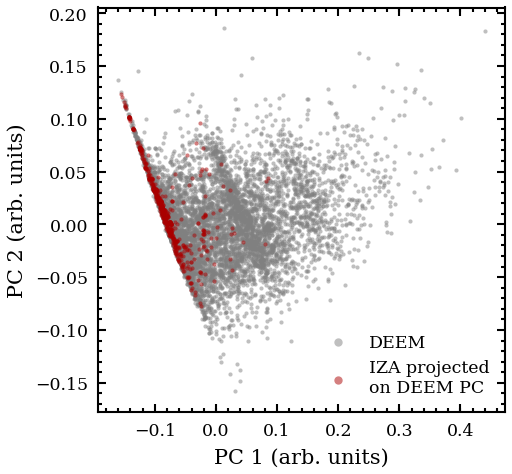

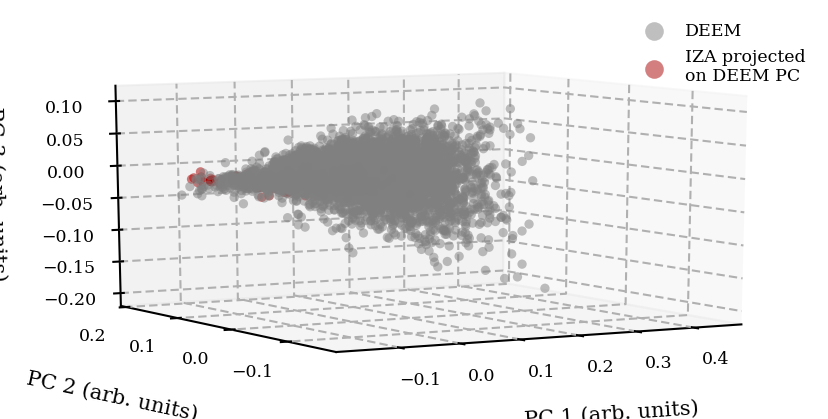

In [187]:
# Load PCA data for IZA and DEEM (3.5 A SOAP cutoff), keep unique environments
udxs_DEEM_PCA_3 = fps_unique('../Processed_Data/DEEM_1k/PCA/3.5/FPS-uPCA.idxs', prec=prec)
udxs_IZA_PCA_3 = fps_unique('../Processed_Data/OPT_IZAonDEEM_1k/PCA/3.5/FPS-uPCA.idxs', prec=prec)
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/3.5/pca-0.npy')[udxs_DEEM_PCA_3, :]
pcaIZA = np.load('../Processed_Data/OPT_IZAonDEEM_1k/PCA/3.5/pca-0.npy')[udxs_IZA_PCA_3, :]

# Eliminate DEEM environments that are essentially IZA environments by proximity
pcaDEEM = iza_deem_unique(pcaDEEM, pcaIZA, prec=prec)

### 2D PCA ###
# Create figure
figPCA = plt.figure(figsize=(3.5, 3.5))

# Create axes
axsScat = figPCA.add_subplot(1, 1, 1)

# Scatter plot of IZA and DEEM
scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA = axsScat.scatter(pcaIZA[:, 0], pcaIZA[:, 1], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and tick sizes
axsScat.set_xlabel('PC 1 (arb. units)')
axsScat.set_ylabel('PC 2 (arb. units)')

# Figure legend
axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

# Save figure
figPCA.savefig('../Results/DEEM_1k/pca_OPT_IZAonDEEM_3.5.png', bbox_inches='tight')

### 3D PCA ###
# Create figure
fig3D = plt.figure(figsize=(7.0, 3.5))

# Create axes
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

# Scatter plot of IZA and DEEM
scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA3D = axs3D.scatter(pcaIZA[:, 0], pcaIZA[:, 1], pcaIZA[:, 2], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and tick sizes
axs3D.set_xlabel('PC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('PC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('PC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])

# View angle
axs3D.view_init(10, -120)

# Custom legend
axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)#, fontsize=24)

fig3D.savefig('../Results/DEEM_1k/pca_OPT_IZAonDEEM_3.5_3D.png', bbox_inches='tight')

plt.show()

Unique points with prec = 8: 6826
Unique points with prec = 8: 670


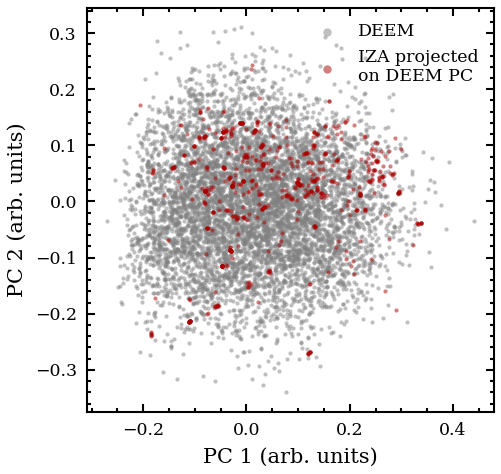

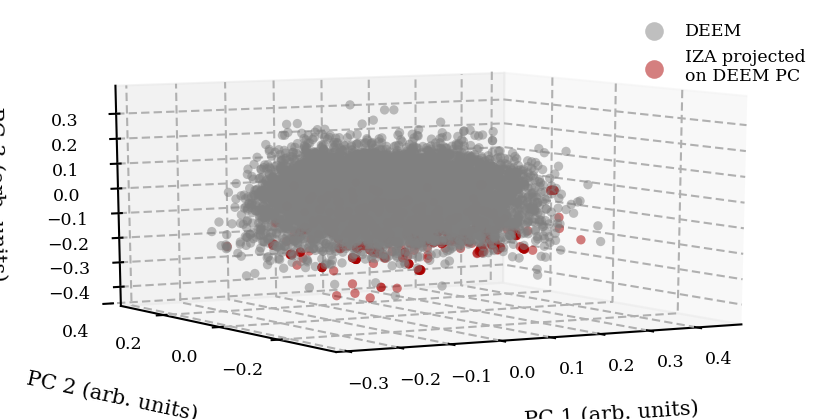

In [188]:
# Load PCA data for IZA and DEEM (6.0 A SOAP cutoff), keep unique environments
udxs_DEEM_PCA_6 = fps_unique('../Processed_Data/DEEM_1k/PCA/6.0/FPS-uPCA.idxs', prec=prec)
udxs_IZA_PCA_6 = fps_unique('../Processed_Data/OPT_IZAonDEEM_1k/PCA/6.0/FPS-uPCA.idxs', prec=prec)
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/6.0/pca-0.npy')[udxs_DEEM_PCA_6, :]
pcaIZA = np.load('../Processed_Data/OPT_IZAonDEEM_1k/PCA/6.0/pca-0.npy')[udxs_IZA_PCA_6, :]

# Eliminate DEEM environments that are essentially IZA environments by proximity
pcaDEEM = iza_deem_unique(pcaDEEM, pcaIZA, prec=prec)

### 2D PCA ###
# Create figure
figPCA = plt.figure(figsize=(3.5, 3.5))

# Create axes
axsScat = figPCA.add_subplot(1, 1, 1)

# Scatter plot
scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA = axsScat.scatter(pcaIZA[:, 0], pcaIZA[:, 1], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels
axsScat.set_xlabel('PC 1 (arb. units)')
axsScat.set_ylabel('PC 2 (arb. units)')

# Custom legend
axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

figPCA.savefig('../Results/DEEM_1k/pca_OPT_IZAonDEEM_6.0.png', bbox_inches='tight')

### 3D PCA ###
# Create figure
fig3D = plt.figure(figsize=(7.0, 3.5))

# Create axes
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

# Scatter plot
scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA3D = axs3D.scatter(pcaIZA[:, 0], pcaIZA[:, 1], pcaIZA[:, 2], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and sizes
axs3D.set_xlabel('PC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('PC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('PC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])

# View angle
axs3D.view_init(10, -120)

# Custom legend
axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

fig3D.savefig('../Results/DEEM_1k/pca_OPT_IZAonDEEM_6.0_3D.png', bbox_inches='tight')

plt.show()

# KPCA Plots

Unique points with prec = 8: 6835
Unique points with prec = 8: 696


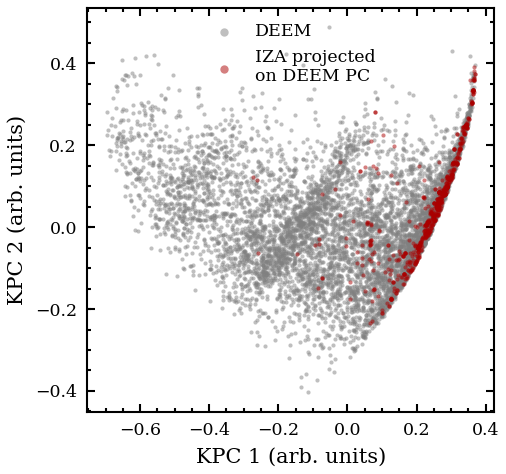

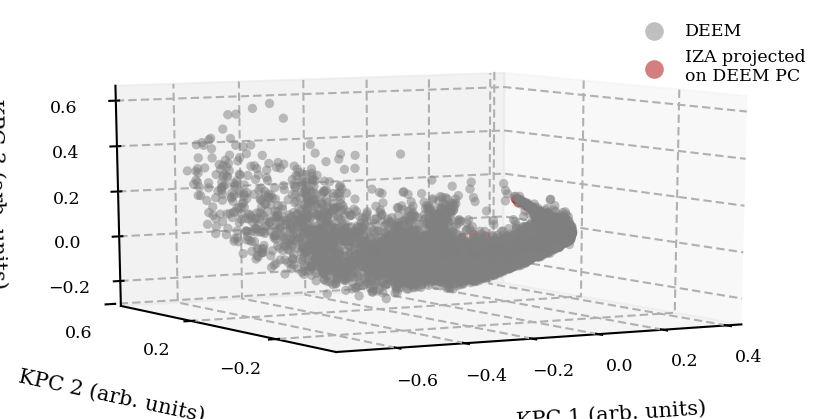

In [189]:
# Load PCA data for IZA and DEEM (3.5 A SOAP cutoff), keep unique environments
udxs_DEEM_KPCA_3 = fps_unique('../Processed_Data/DEEM_1k/PCA/3.5/FPS-uKPCA.idxs', prec=prec)
udxs_IZA_KPCA_3 = fps_unique('../Processed_Data/OPT_IZAonDEEM_1k/PCA/3.5/FPS-uKPCA.idxs', prec=prec)
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')[udxs_DEEM_KPCA_3, :]
pcaIZA = np.load('../Processed_Data/OPT_IZAonDEEM_1k/PCA/3.5/kpca_proj.npy')[udxs_IZA_KPCA_3, :]

# Eliminate DEEM environments that are essentially IZA environments by proximity
pcaDEEM = iza_deem_unique(pcaDEEM, pcaIZA, prec=prec)

### 2D PCA ###
# Create figure
figPCA = plt.figure(figsize=(3.5, 3.5))

# Create axes
axsScat = figPCA.add_subplot(1, 1, 1)

# Scatter plot of IZA and DEEM
scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA = axsScat.scatter(pcaIZA[:, 0], pcaIZA[:, 1], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and tick sizes
axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

# Figure legend
axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

# Save figure
figPCA.savefig('../Results/DEEM_1k/kpca_OPT_IZAonDEEM_3.5.png', bbox_inches='tight')

### 3D PCA ###
# Create figure
fig3D = plt.figure(figsize=(7.0, 3.5))

# Create axes
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

# Scatter plot
scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA3D = axs3D.scatter(pcaIZA[:, 0], pcaIZA[:, 1], pcaIZA[:, 2], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and ticks
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])

# View angle
axs3D.view_init(10, -120)

# Figure legend
axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)#, fontsize=24)

fig3D.savefig('../Results/DEEM_1k/kpca_OPT_IZAonDEEM_3.5_3D.png', bbox_inches='tight')

plt.show()

Unique points with prec = 8: 6826
Unique points with prec = 8: 669


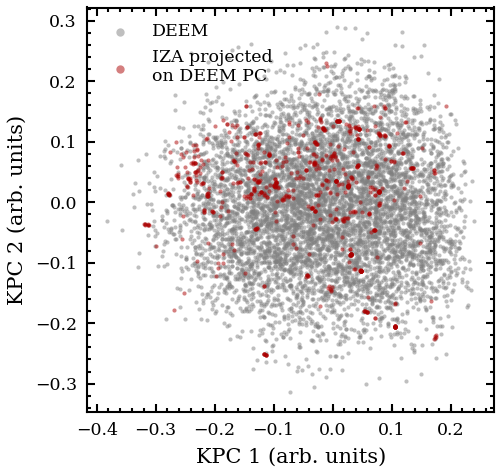

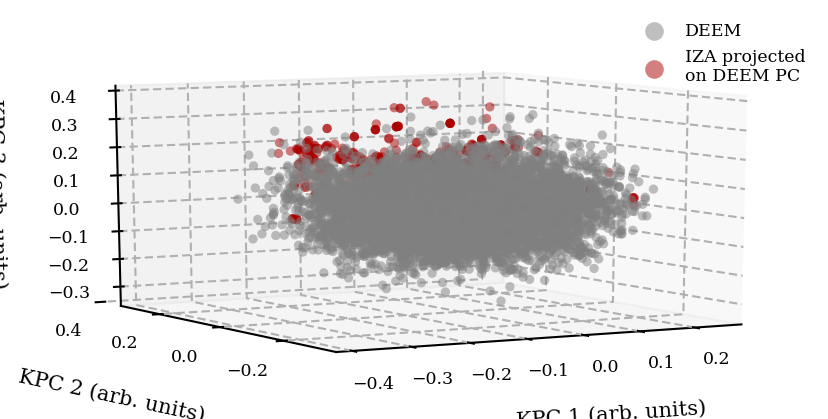

In [190]:
# Load PCA data for IZA and DEEM (6.0 A SOAP cutoff), keep unique environments
udxs_DEEM_KPCA_6 = fps_unique('../Processed_Data/DEEM_1k/PCA/6.0/FPS-uKPCA.idxs', prec=prec)
udxs_IZA_KPCA_6 = fps_unique('../Processed_Data/OPT_IZAonDEEM_1k/PCA/6.0/FPS-uKPCA.idxs', prec=prec)
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')[udxs_DEEM_KPCA_6, :]
pcaIZA = np.load('../Processed_Data/OPT_IZAonDEEM_1k/PCA/6.0/kpca_proj.npy')[udxs_IZA_KPCA_6, :]

# Eliminate DEEM environments that are essentially IZA environments by proximity
pcaDEEM = iza_deem_unique(pcaDEEM, pcaIZA, prec=prec)

### 2D PCA ###
# Create figure
figPCA = plt.figure(figsize=(3.5, 3.5))

# Create axes
axsScat = figPCA.add_subplot(1, 1, 1)

# Scatter plot
scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA = axsScat.scatter(pcaIZA[:, 0], pcaIZA[:, 1], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels
axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

# Figure legend
axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

figPCA.savefig('../Results/DEEM_1k/kpca_OPT_IZAonDEEM_6.0.png', bbox_inches='tight')

### 3D PCA ###
# Create figure
fig3D = plt.figure(figsize=(7.0, 3.5))

# Create axes
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

# Scatter plot
scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA3D = axs3D.scatter(pcaIZA[:, 0], pcaIZA[:, 1], pcaIZA[:, 2], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and tick setup
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])

# View angle
axs3D.view_init(10, -120)

# Figure legend
axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

fig3D.savefig('../Results/DEEM_1k/kpca_OPT_IZAonDEEM_6.0_3D.png', bbox_inches='tight')

plt.show()

# Environment Properties

In [191]:
# Load environment properties
DEEM_E_3 = np.loadtxt('../Processed_Data/DEEM_1k/Energy/3.5/Gaussian/envProperties-0.dat')
DEEM_V_3 = np.loadtxt('../Processed_Data/DEEM_1k/Volume/3.5/Gaussian/envProperties-0.dat')
IZA_E_3 = np.loadtxt('../Processed_Data/OPT_IZAonDEEM_1k/Energy/3.5/Gaussian/envProperties_proj-0.dat')
IZA_V_3 = np.loadtxt('../Processed_Data/OPT_IZAonDEEM_1k/Volume/3.5/Gaussian/envProperties_proj-0.dat')

DEEM_E_6 = np.loadtxt('../Processed_Data/DEEM_1k/Energy/6.0/Gaussian/envProperties-0.dat')
DEEM_V_6 = np.loadtxt('../Processed_Data/DEEM_1k/Volume/6.0/Gaussian/envProperties-0.dat')
IZA_E_6 = np.loadtxt('../Processed_Data/OPT_IZAonDEEM_1k/Energy/6.0/Gaussian/envProperties_proj-0.dat')
IZA_V_6 = np.loadtxt('../Processed_Data/OPT_IZAonDEEM_1k/Volume/6.0/Gaussian/envProperties_proj-0.dat')

# Atoms data and structure properties
DEEM_atoms = np.loadtxt('../Processed_Data/DEEM_1k/atoms.dat', usecols=(7, 8, 9))
IZA_atoms = np.loadtxt('../Processed_Data/OPT_IZA/atoms.dat', usecols=(7, 8))

In [192]:
# Get unique IDs and the index of the first atom in each structure
IZA_u, IZA_idxs = np.unique(IZA_atoms[:, 0], return_index=True)
DEEM_u, DEEM_idxs = np.unique(DEEM_atoms[:, 0], return_index=True)

# Parse structure volumes and/or energies
IZA_V = IZA_atoms[IZA_idxs, 1]
DEEM_V = DEEM_atoms[DEEM_idxs, 1]
DEEM_E = DEEM_atoms[DEEM_idxs, 2]

# Initialize matrices to hold sum
# of environment properties for each structure
IZA_V_3_sum = np.zeros(IZA_u.size)
IZA_V_6_sum = np.zeros(IZA_u.size)

DEEM_V_3_sum = np.zeros(DEEM_u.size)
DEEM_V_6_sum = np.zeros(DEEM_u.size)

DEEM_E_3_sum = np.zeros(DEEM_u.size)
DEEM_E_6_sum = np.zeros(DEEM_u.size)

# Get number of Si atoms in each DEEM structure
DEEM_n_atoms = np.zeros(DEEM_u.size)
DEEM_n_atoms[0:-1] = np.diff(DEEM_idxs)
DEEM_n_atoms[-1] = DEEM_atoms.shape[0] - DEEM_idxs[-1]

# Mean-center the structure energies
DEEM_E_avg = DEEM_E*DEEM_n_atoms - np.mean(DEEM_E)*DEEM_n_atoms

# Compute MAE (as %) of IZA structure volumes and environment volume sum
for i in IZA_u.astype(np.int):
    idxs = IZA_atoms[:, 0] == i
    IZA_V_3_sum[i] = (IZA_V[i] - np.sum(IZA_V_3[idxs]))/IZA_V[i]
    IZA_V_6_sum[i] = (IZA_V[i] - np.sum(IZA_V_6[idxs]))/IZA_V[i]

# Compute MAE (as %) of DEEM structure volumes and environment volume sum
for i in DEEM_u.astype(np.int):
    idxs = DEEM_atoms[:, 0] == i
    
    DEEM_V_3_sum[i] = (DEEM_V[i] - np.sum(DEEM_V_3[idxs]))/DEEM_V[i]
    DEEM_V_6_sum[i] = (DEEM_V[i] - np.sum(DEEM_V_6[idxs]))/DEEM_V[i]
    
    DEEM_E_3_sum[i] = (DEEM_E_avg[i] - np.sum(DEEM_E_3[idxs]))/DEEM_E_avg[i]
    DEEM_E_6_sum[i] = (DEEM_E_avg[i] - np.sum(DEEM_E_6[idxs]))/DEEM_E_avg[i]
    
print "IZA V 3.5: ", np.mean(np.abs(IZA_V_3_sum))*100, np.mean(np.abs(IZA_V_3_sum*IZA_V))
print "IZA V 6.0: ", np.mean(np.abs(IZA_V_6_sum))*100, np.mean(np.abs(IZA_V_6_sum*IZA_V))

print "DEEM V 3.5: ", np.mean(np.abs(DEEM_V_3_sum))*100, np.mean(np.abs(DEEM_V_3_sum*DEEM_V))
print "DEEM V 6.0: ", np.mean(np.abs(DEEM_V_6_sum))*100, np.mean(np.abs(DEEM_V_6_sum*DEEM_V))

print "DEEM E 3.5: ", np.mean(np.abs(DEEM_E_3_sum))*100, np.mean(np.abs(DEEM_E_3_sum*DEEM_E_avg))
print "DEEM E 6.0: ", np.mean(np.abs(DEEM_E_6_sum))*100, np.mean(np.abs(DEEM_E_6_sum*DEEM_E_avg))

IZA V 3.5:  8.800235625451196 352.1787580188311
IZA V 6.0:  2.6031811881253324 100.90231303333326
DEEM V 3.5:  4.350704255756063 130.0925149019119
DEEM V 6.0:  1.8101296437672256 58.68443763438869
DEEM E 3.5:  45.85248616769142 26.362392663406034
DEEM E 6.0:  32.98119293926473 20.016029723259127


# SVM Classification

## 3.5

In [210]:
# Load SOAP, PCA, and KPCA data for SVM classification, retain only unique environments
udxs_IZA_SOAP_3 = fps_unique('../Processed_Data/OPT_IZAonDEEM_1k/PCA/3.5/FPS-uSOAP.idxs', prec=prec)
udxs_DEEM_SOAP_3 = fps_unique('../Processed_Data/DEEM_1k/PCA/3.5/FPS-uSOAP.idxs', prec=prec)
IZA_SOAP = np.load('../Processed_Data/OPT_IZAonDEEM_1k/PCA/3.5/SOAPs-0.npy')[udxs_IZA_SOAP_3, :]
DEEM_SOAP = np.load('../Processed_Data/DEEM_1k/PCA/3.5/SOAPs-0.npy')[udxs_DEEM_SOAP_3, :]
DEEM_SOAP = iza_deem_unique(DEEM_SOAP, IZA_SOAP, prec=prec)

IZA_PCA = np.load('../Processed_Data/OPT_IZAonDEEM_1k/PCA/3.5/pca-0.npy')[udxs_IZA_PCA_3, :]
DEEM_PCA = np.load('../Processed_Data/DEEM_1k/PCA/3.5/pca-0.npy')[udxs_DEEM_PCA_3]
pcaDEEM = iza_deem_unique(DEEM_PCA, IZA_PCA, prec=prec)

IZA_KPCA = np.load('../Processed_Data/OPT_IZAonDEEM_1k/PCA/3.5/kpca_proj.npy')[udxs_IZA_KPCA_3, :]
DEEM_KPCA = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')[udxs_DEEM_KPCA_3, :]
DEEM_KPCA = iza_deem_unique(DEEM_KPCA, IZA_KPCA, prec=prec)

Unique points with prec = 8: 549
Unique points with prec = 8: 6826


In [211]:
# Fraction of points to use for training
f_train = 0.8

# Set number of train and test samples
# assuming IZA will have fewer samples and
# using the same number of training and test
# samples for both IZA and DEEM;
# We do this independently for SOAP, PCA, and KPCA
# b/c they may not have the same number
# of unique environments
n_IZA_SOAP = IZA_SOAP.shape[0]
n_DEEM_SOAP = DEEM_SOAP.shape[0]
n_train_SOAP = int(f_train*n_IZA_SOAP)
n_test_SOAP = n_IZA_SOAP - n_train_SOAP

print n_IZA_SOAP
print n_DEEM_SOAP
print n_train_SOAP
print n_test_SOAP

n_IZA_PCA = IZA_PCA.shape[0]
n_DEEM_PCA = DEEM_PCA.shape[0]
n_train_PCA = int(f_train*n_IZA_PCA)
n_test_PCA = n_IZA_PCA - n_train_PCA

print n_IZA_PCA
print n_DEEM_PCA
print n_train_PCA
print n_test_PCA

n_IZA_KPCA = IZA_KPCA.shape[0]
n_DEEM_KPCA = DEEM_KPCA.shape[0]
n_train_KPCA = int(f_train*n_IZA_KPCA)
n_test_KPCA = n_IZA_KPCA - n_train_KPCA

print n_IZA_KPCA
print n_DEEM_KPCA
print n_train_KPCA
print n_test_KPCA

549
6826
439
110
550
6826
440
110
696
6835
556
140


In [212]:
# Set indices for training and testing
IZA_train_SOAP, IZA_test_SOAP, \
        DEEM_train_SOAP, DEEM_test_SOAP, \
        shuffle_train_idxs_SOAP, shuffle_test_idxs_SOAP = rand_idxs(n_IZA_SOAP, n_DEEM_SOAP, 
                                                                    n_train_SOAP, n_test_SOAP)
IZA_train_PCA, IZA_test_PCA, \
        DEEM_train_PCA, DEEM_test_PCA, \
        shuffle_train_idxs_PCA, shuffle_test_idxs_PCA = rand_idxs(n_IZA_PCA, n_DEEM_PCA, 
                                                                    n_train_PCA, n_test_PCA)
IZA_train_KPCA, IZA_test_KPCA, \
        DEEM_train_KPCA, DEEM_test_KPCA, \
        shuffle_train_idxs_KPCA, shuffle_test_idxs_KPCA = rand_idxs(n_IZA_KPCA, n_DEEM_KPCA, 
                                                                    n_train_KPCA, n_test_KPCA)

# Scale the data to have mean zero and standard deviation unity;
# build arrays of classification labels
SOAP_train = np.concatenate((IZA_SOAP[IZA_train_SOAP], DEEM_SOAP[DEEM_train_SOAP]))[shuffle_train_idxs_SOAP]
SOAP_test = np.concatenate((IZA_SOAP[IZA_test_SOAP], DEEM_SOAP[DEEM_test_SOAP]))[shuffle_test_idxs_SOAP]
u_SOAP = np.mean(np.concatenate((SOAP_train, SOAP_test)), axis=0)
s_SOAP = np.std(np.concatenate((SOAP_train, SOAP_test)), axis=0)
SOAP_train = (SOAP_train - u_SOAP)/s_SOAP
SOAP_test = (SOAP_test - u_SOAP)/s_SOAP
train_labels_SOAP = np.asarray(['IZA']*n_train_SOAP + ['DEEM']*n_train_SOAP)[shuffle_train_idxs_SOAP]
test_labels_SOAP = np.asarray(['IZA']*n_test_SOAP + ['DEEM']*n_test_SOAP)[shuffle_test_idxs_SOAP]

PCA_train = np.concatenate((IZA_PCA[IZA_train_PCA], DEEM_PCA[DEEM_train_PCA]))[shuffle_train_idxs_PCA]
PCA_test = np.concatenate((IZA_PCA[IZA_test_PCA], DEEM_PCA[DEEM_test_PCA]))[shuffle_test_idxs_PCA]
u_PCA = np.mean(np.concatenate((PCA_train, PCA_test)), axis=0)
s_PCA = np.std(np.concatenate((PCA_train, PCA_test)), axis=0)
PCA_train = (PCA_train - u_PCA)/s_PCA
PCA_test = (PCA_test - u_PCA)/s_PCA
train_labels_PCA = np.asarray(['IZA']*n_train_PCA + ['DEEM']*n_train_PCA)[shuffle_train_idxs_PCA]
test_labels_PCA = np.asarray(['IZA']*n_test_PCA + ['DEEM']*n_test_PCA)[shuffle_test_idxs_PCA]

KPCA_train = np.concatenate((IZA_KPCA[IZA_train_KPCA], DEEM_KPCA[DEEM_train_KPCA]))[shuffle_train_idxs_KPCA]
KPCA_test = np.concatenate((IZA_KPCA[IZA_test_KPCA], DEEM_KPCA[DEEM_test_KPCA]))[shuffle_test_idxs_KPCA]
u_KPCA = np.mean(np.concatenate((KPCA_train, KPCA_test)), axis=0)
s_KPCA = np.std(np.concatenate((KPCA_train, KPCA_test)), axis=0)
KPCA_train = (KPCA_train - u_KPCA)/s_KPCA
KPCA_test = (KPCA_test - u_KPCA)/s_KPCA
train_labels_KPCA = np.asarray(['IZA']*n_train_KPCA + ['DEEM']*n_train_KPCA)[shuffle_train_idxs_KPCA]
test_labels_KPCA = np.asarray(['IZA']*n_test_KPCA + ['DEEM']*n_test_KPCA)[shuffle_test_idxs_KPCA]

In [214]:
# Train SVC

# SOAP
svc_SOAP = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_SOAP.fit(SOAP_train, train_labels_SOAP)

# Mean accuracy
SOAP_score = svc_SOAP.score(SOAP_test, test_labels_SOAP)

# Predicted labels
SOAP_labels = svc_SOAP.predict(SOAP_test)

# Build (mis)classification matrix
n_samples, m_SOAP = tabulate(SOAP_labels, test_labels_SOAP)
print "SOAP: ", SOAP_score
print m_SOAP

# PCA
n_PCA = 50
svc_PCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_PCA.fit(PCA_train[:, 0:n_PCA], train_labels_PCA)

# Mean accuracy
PCA_score = svc_PCA.score(PCA_test[:, 0:n_PCA], test_labels_PCA)

# Predicted labels
PCA_labels = svc_PCA.predict(PCA_test[:, 0:n_PCA])

# Build (mis)classification matrix
n_samples, m_PCA = tabulate(PCA_labels, test_labels_PCA)
print "PCA: ", PCA_score
print m_PCA

# KPCA
n_KPCA = 50
svc_KPCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_KPCA.fit(KPCA_train[:, 0:n_KPCA], train_labels_KPCA)

# Mean accuracy
KPCA_score = svc_KPCA.score(KPCA_test[:, 0:n_KPCA], test_labels_KPCA)

# Predicted labels
KPCA_labels = svc_KPCA.predict(KPCA_test[:, 0:n_KPCA])

# Build (mis)classification matrix
n_samples, m_KPCA = tabulate(KPCA_labels, test_labels_KPCA)
print "KPCA: ", KPCA_score
print m_PCA

SOAP:  0.8909090909090909
[[0.46818182 0.03181818]
 [0.07727273 0.42272727]]
PCA:  0.9045454545454545
[[0.46818182 0.03181818]
 [0.06363636 0.43636364]]
KPCA:  0.8964285714285715
[[0.46818182 0.03181818]
 [0.06363636 0.43636364]]


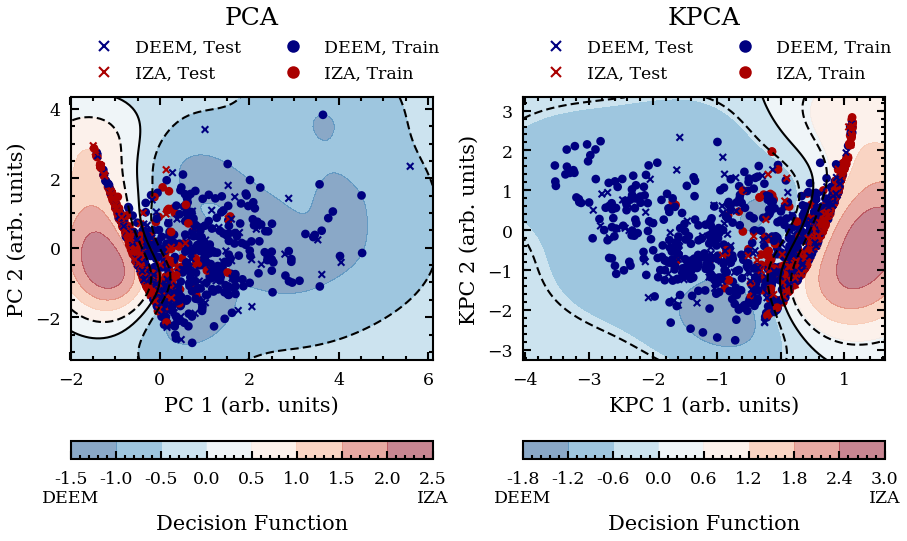

In [201]:
# Plot the SVM

# Create figure and axes
fig = plt.figure(figsize=(7.0, 3.5))
axs_PCA = fig.add_subplot(1, 2, 1)
axs_KPCA = fig.add_subplot(1, 2, 2)

# Assign colors for the data points
colors_train_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_PCA]
colors_test_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_PCA]

colors_train_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_KPCA]
colors_test_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_KPCA]

# Determine bounds for PCA decision function contour
PCA_min_x = np.amin(np.concatenate((PCA_train, PCA_test))[:, 0])
PCA_min_y = np.amin(np.concatenate((PCA_train, PCA_test))[:, 1])
PCA_max_x = np.amax(np.concatenate((PCA_train, PCA_test))[:, 0])
PCA_max_y = np.amax(np.concatenate((PCA_train, PCA_test))[:, 1])

# Build grid for PCA decision function
PCA_xx, PCA_yy = np.meshgrid(np.linspace(PCA_min_x-0.5, PCA_max_x+0.5, 100),
                             np.linspace(PCA_min_y-0.5, PCA_max_y+0.5, 100))

# Compute the PCA decision function
df_PCA = svc_PCA.decision_function(np.column_stack((PCA_xx.ravel(), PCA_yy.ravel())))
df_PCA = np.reshape(df_PCA, PCA_xx.shape)

# Determine bounds for KPCA decision function contour
KPCA_min_x = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 0])
KPCA_min_y = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 1])
KPCA_max_x = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 0])
KPCA_max_y = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 1])

# Build grid for KPCA decision function
KPCA_xx, KPCA_yy = np.meshgrid(np.linspace(KPCA_min_x-0.5, KPCA_max_x+0.5, 100),
                               np.linspace(KPCA_min_y-0.5, KPCA_max_y+0.5, 100))

# Compute the KPCA decision function
df_KPCA = svc_KPCA.decision_function(np.column_stack((KPCA_xx.ravel(), KPCA_yy.ravel())))
df_KPCA = np.reshape(df_KPCA, KPCA_xx.shape)

# Plot decision functions and scatter plot
contour_PCA = axs_PCA.contourf(PCA_xx, PCA_yy, df_PCA, cmap='RdBu_r', alpha=0.5)
axs_PCA.contour(PCA_xx, PCA_yy, df_PCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_PCA.scatter(PCA_train[:, 0], PCA_train[:, 1], marker='o', c=colors_train_PCA[:], s=10)
axs_PCA.scatter(PCA_test[:, 0], PCA_test[:, 1], marker='x', c=colors_test_PCA[:], s=10)

contour_KPCA = axs_KPCA.contourf(KPCA_xx, KPCA_yy, df_KPCA, cmap='RdBu_r', alpha=0.5)
axs_KPCA.contour(KPCA_xx, KPCA_yy, df_KPCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_KPCA.scatter(KPCA_train[:, 0], KPCA_train[:, 1], marker='o', c=colors_train_KPCA[:], s=10)
axs_KPCA.scatter(KPCA_test[:, 0], KPCA_test[:, 1], marker='x', c=colors_test_KPCA[:], s=10)

# Axes labels
axs_PCA.set_xlabel('PC 1 (arb. units)')
axs_PCA.set_ylabel('PC 2 (arb. units)')

axs_KPCA.set_xlabel('KPC 1 (arb. units)')
axs_KPCA.set_ylabel('KPC 2 (arb. units)')

# Custom legend entries
xblue = mpllines.Line2D([], [], color=colorList[2], marker='x', 
                        markersize=5, linestyle='None', label='DEEM, Test')
oblue = mpllines.Line2D([], [], color=colorList[2], marker='o', 
                        markersize=5, linestyle='None', label='DEEM, Train')
xred = mpllines.Line2D([], [], color=colorList[1], marker='x',
                      markersize=5, linestyle='None', label='IZA, Test')
ored = mpllines.Line2D([], [], color=colorList[1], marker='o',
                      markersize=5, linestyle='None', label='IZA, Train')

# Custom legend
axs_PCA.legend(handles=(xblue, xred, oblue, ored), loc='lower left', 
               bbox_to_anchor=(0.0, 1.0), ncol=2)
axs_KPCA.legend(handles=(xblue, xred, oblue, ored), loc='lower left', 
               bbox_to_anchor=(0.0, 1.0), ncol=2)

# Axes titles
axs_PCA.set_title('PCA', pad=35)
axs_KPCA.set_title('KPCA', pad=35)

# Colorbars for decision function with custom tick labels
cb_PCA = fig.colorbar(contour_PCA, ax=axs_PCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')
cb_KPCA = fig.colorbar(contour_KPCA, ax=axs_KPCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')

cb_PCA_ticks = ['%.1f' % i for i in cb_PCA.get_ticks()]
cb_PCA_ticks[0] = cb_PCA_ticks[0] + '\nDEEM'
cb_PCA_ticks[-1] = cb_PCA_ticks[-1] + '\nIZA'
cb_PCA.set_ticklabels(cb_PCA_ticks)

cb_KPCA_ticks = ['%.1f' % i for i in cb_KPCA.get_ticks()]
cb_KPCA_ticks[0] = cb_KPCA_ticks[0] + '\nDEEM'
cb_KPCA_ticks[-1] = cb_KPCA_ticks[-1] + '\nIZA'
cb_KPCA.set_ticklabels(cb_KPCA_ticks)

fig.subplots_adjust(wspace=0.25)

fig.savefig('../Results/DEEM_1k/svm_OPT_IZAonDEEM_3.5.png', bbox_inches='tight')

plt.show()

## 6.0

In [215]:
# Load SOAP, PCA, and KPCA data for SVM classification, retain only unique environments
udxs_IZA_SOAP_6 = fps_unique('../Processed_Data/OPT_IZAonDEEM_1k/PCA/6.0/FPS-uSOAP.idxs', prec=prec)
udxs_DEEM_SOAP_6 = fps_unique('../Processed_Data/DEEM_1k/PCA/6.0/FPS-uSOAP.idxs', prec=prec)
IZA_SOAP = np.load('../Processed_Data/OPT_IZAonDEEM_1k/PCA/6.0/SOAPs-0.npy')[udxs_IZA_SOAP_6, :]
DEEM_SOAP = np.load('../Processed_Data/DEEM_1k/PCA/6.0/SOAPs-0.npy')[udxs_DEEM_SOAP_6, :]
DEEM_SOAP = iza_deem_unique(DEEM_SOAP, IZA_SOAP, prec=prec)

IZA_PCA = np.load('../Processed_Data/OPT_IZAonDEEM_1k/PCA/6.0/pca-0.npy')[udxs_IZA_PCA_6, :]
DEEM_PCA = np.load('../Processed_Data/DEEM_1k/PCA/6.0/pca-0.npy')[udxs_DEEM_PCA_6, :]
DEEM_PCA = iza_deem_unique(DEEM_PCA, IZA_PCA, prec=prec)

IZA_KPCA = np.load('../Processed_Data/OPT_IZAonDEEM_1k/PCA/6.0/kpca_proj.npy')[udxs_IZA_KPCA_6, :]
DEEM_KPCA = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')[udxs_DEEM_KPCA_6, :]
DEEM_KPCA = iza_deem_unique(DEEM_KPCA, IZA_KPCA, prec=prec)

Unique points with prec = 8: 670
Unique points with prec = 8: 6826


In [216]:
# Fraction of points to use for training
f_train = 0.8

# Set number of train and test samples
# assuming IZA will have fewer samples and
# using the same number of training and test
# samples for both IZA and DEEM;
# We do this independently for SOAP, PCA, and KPCA
# b/c they may not have the same number
# of unique environments
n_IZA_SOAP = IZA_SOAP.shape[0]
n_DEEM_SOAP = DEEM_SOAP.shape[0]
n_train_SOAP = int(f_train*n_IZA_SOAP)
n_test_SOAP = n_IZA_SOAP - n_train_SOAP

print n_IZA_SOAP
print n_DEEM_SOAP
print n_train_SOAP
print n_test_SOAP

n_IZA_PCA = IZA_PCA.shape[0]
n_DEEM_PCA = DEEM_PCA.shape[0]
n_train_PCA = int(f_train*n_IZA_PCA)
n_test_PCA = n_IZA_PCA - n_train_PCA

print n_IZA_PCA
print n_DEEM_PCA
print n_train_PCA
print n_test_PCA

n_IZA_KPCA = IZA_KPCA.shape[0]
n_DEEM_KPCA = DEEM_KPCA.shape[0]
n_train_KPCA = int(f_train*n_IZA_KPCA)
n_test_KPCA = n_IZA_KPCA - n_train_KPCA

print n_IZA_KPCA
print n_DEEM_KPCA
print n_train_KPCA
print n_test_KPCA

670
6826
536
134
670
6826
536
134
669
6826
535
134


In [222]:
# Set indices for testing and training
IZA_train_SOAP, IZA_test_SOAP, \
        DEEM_train_SOAP, DEEM_test_SOAP, \
        shuffle_train_idxs_SOAP, shuffle_test_idxs_SOAP = rand_idxs(n_IZA_SOAP, n_DEEM_SOAP, 
                                                                    n_train_SOAP, n_test_SOAP)
IZA_train_PCA, IZA_test_PCA, \
        DEEM_train_PCA, DEEM_test_PCA, \
        shuffle_train_idxs_PCA, shuffle_test_idxs_PCA = rand_idxs(n_IZA_PCA, n_DEEM_PCA, 
                                                                    n_train_PCA, n_test_PCA)
IZA_train_KPCA, IZA_test_KPCA, \
        DEEM_train_KPCA, DEEM_test_KPCA, \
        shuffle_train_idxs_KPCA, shuffle_test_idxs_KPCA = rand_idxs(n_IZA_KPCA, n_DEEM_KPCA, 
                                                                    n_train_KPCA, n_test_KPCA)
    
# Scale the data to have mean zero and standard deviation unity;
# build arrays of classification labels
SOAP_train = np.concatenate((IZA_SOAP[IZA_train_SOAP], DEEM_SOAP[DEEM_train_SOAP]))[shuffle_train_idxs_SOAP]
SOAP_test = np.concatenate((IZA_SOAP[IZA_test_SOAP], DEEM_SOAP[DEEM_test_SOAP]))[shuffle_test_idxs_SOAP]
u_SOAP = np.mean(np.concatenate((SOAP_train, SOAP_test)), axis=0)
s_SOAP = np.std(np.concatenate((SOAP_train, SOAP_test)), axis=0)
SOAP_train = (SOAP_train - u_SOAP)/s_SOAP
SOAP_test = (SOAP_test - u_SOAP)/s_SOAP
train_labels_SOAP = np.asarray(['IZA']*n_train_SOAP + ['DEEM']*n_train_SOAP)[shuffle_train_idxs_SOAP]
test_labels_SOAP = np.asarray(['IZA']*n_test_SOAP + ['DEEM']*n_test_SOAP)[shuffle_test_idxs_SOAP]

PCA_train = np.concatenate((IZA_PCA[IZA_train_PCA], DEEM_PCA[DEEM_train_PCA]))[shuffle_train_idxs_PCA]
PCA_test = np.concatenate((IZA_PCA[IZA_test_PCA], DEEM_PCA[DEEM_test_PCA]))[shuffle_test_idxs_PCA]
u_PCA = np.mean(np.concatenate((PCA_train, PCA_test)), axis=0)
s_PCA = np.std(np.concatenate((PCA_train, PCA_test)), axis=0)
PCA_train = (PCA_train - u_PCA)/s_PCA
PCA_test = (PCA_test - u_PCA)/s_PCA
train_labels_PCA = np.asarray(['IZA']*n_train_PCA + ['DEEM']*n_train_PCA)[shuffle_train_idxs_PCA]
test_labels_PCA = np.asarray(['IZA']*n_test_PCA + ['DEEM']*n_test_PCA)[shuffle_test_idxs_PCA]

KPCA_train = np.concatenate((IZA_KPCA[IZA_train_KPCA], DEEM_KPCA[DEEM_train_KPCA]))[shuffle_train_idxs_KPCA]
KPCA_test = np.concatenate((IZA_KPCA[IZA_test_KPCA], DEEM_KPCA[DEEM_test_KPCA]))[shuffle_test_idxs_KPCA]
u_KPCA = np.mean(np.concatenate((KPCA_train, KPCA_test)), axis=0)
s_KPCA = np.std(np.concatenate((KPCA_train, KPCA_test)), axis=0)
KPCA_train = (KPCA_train - u_KPCA)/s_KPCA
KPCA_test = (KPCA_test - u_KPCA)/s_KPCA
train_labels_KPCA = np.asarray(['IZA']*n_train_KPCA + ['DEEM']*n_train_KPCA)[shuffle_train_idxs_KPCA]
test_labels_KPCA = np.asarray(['IZA']*n_test_KPCA + ['DEEM']*n_test_KPCA)[shuffle_test_idxs_KPCA]

In [225]:
# Train SVC

# SOAP
svc_SOAP = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_SOAP.fit(SOAP_train, train_labels_SOAP)

# Mean accuracy
SOAP_score = svc_SOAP.score(SOAP_test, test_labels_SOAP)

# Predicted labels
SOAP_labels = svc_SOAP.predict(SOAP_test)

# Build (mis)classification matrix
n_samples, m_SOAP = tabulate(SOAP_labels, test_labels_SOAP)
print "SOAP: ", SOAP_score
print m_SOAP

# PCA
n_PCA = 2
svc_PCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_PCA.fit(PCA_train[:, 0:n_PCA], train_labels_PCA)

# Mean accuracy
PCA_score = svc_PCA.score(PCA_test[:, 0:n_PCA], test_labels_PCA)

# Predicted labels
PCA_labels = svc_PCA.predict(PCA_test[:, 0:n_PCA])

# Build (mis)classification matrix
n_samples, m_PCA = tabulate(PCA_labels, test_labels_PCA)
print "PCA: ", PCA_score
print m_PCA

# KPCA
n_KPCA = 2
svc_KPCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_KPCA.fit(KPCA_train[:, 0:n_KPCA], train_labels_KPCA)

# Mean accuracy
KPCA_score = svc_KPCA.score(KPCA_test[:, 0:n_KPCA], test_labels_KPCA)

# Predicted labels
KPCA_labels = svc_KPCA.predict(KPCA_test[:, 0:n_KPCA])

# Build (mis)classification matrix
n_samples, m_KPCA = tabulate(KPCA_labels, test_labels_KPCA)
print "KPCA: ", KPCA_score
print m_KPCA

SOAP:  0.9776119402985075
[[0.48880597 0.01119403]
 [0.01119403 0.48880597]]
PCA:  0.664179104477612
[[0.37313433 0.12686567]
 [0.20895522 0.29104478]]
KPCA:  0.7164179104477612
[[0.39179104 0.10820896]
 [0.17537313 0.32462687]]


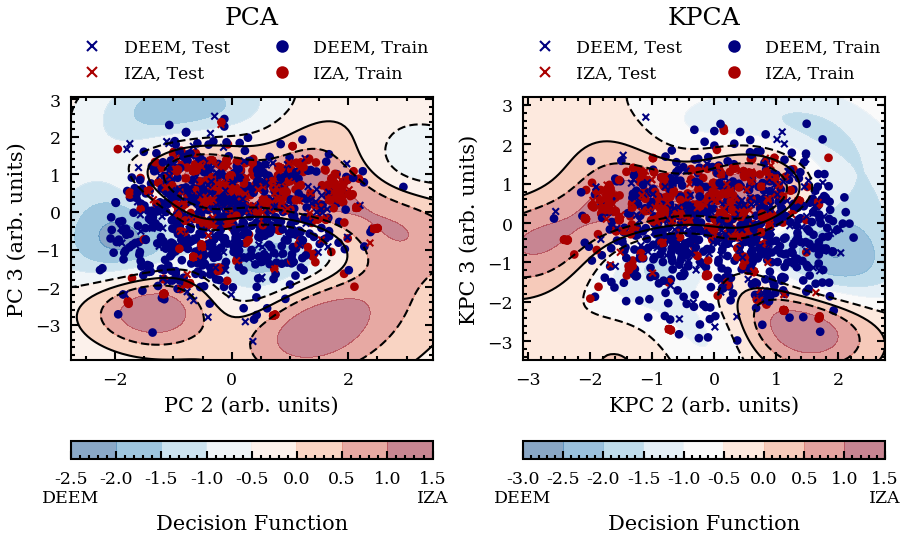

In [162]:
# Plot the SVM

# Create figure and axes
fig = plt.figure(figsize=(7.0, 3.5))
axs_PCA = fig.add_subplot(1, 2, 1)
axs_KPCA = fig.add_subplot(1, 2, 2)

# Assign colors for the scatter points
colors_train_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_PCA]
colors_test_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_PCA]

colors_train_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_KPCA]
colors_test_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_KPCA]

# Determine bounds for the PCA decision function contour
PCA_min_x = np.amin(np.concatenate((PCA_train, PCA_test))[:, 0])
PCA_min_y = np.amin(np.concatenate((PCA_train, PCA_test))[:, 1])
PCA_max_x = np.amax(np.concatenate((PCA_train, PCA_test))[:, 0])
PCA_max_y = np.amax(np.concatenate((PCA_train, PCA_test))[:, 1])

# Build grid for PCA decision function contour
PCA_xx, PCA_yy = np.meshgrid(np.linspace(PCA_min_x-0.5, PCA_max_x+0.5, 100),
                             np.linspace(PCA_min_y-0.5, PCA_max_y+0.5, 100))

# Compute PCA decision function
df_PCA = svc_PCA.decision_function(np.column_stack((PCA_xx.ravel(), PCA_yy.ravel())))
df_PCA = np.reshape(df_PCA, PCA_xx.shape)

# Determine bounds for the KPCA decision function contour
KPCA_min_x = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 0])
KPCA_min_y = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 1])
KPCA_max_x = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 0])
KPCA_max_y = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 1])

# Build grid for KPCA decision function contour
KPCA_xx, KPCA_yy = np.meshgrid(np.linspace(KPCA_min_x-0.5, KPCA_max_x+0.5, 100),
                               np.linspace(KPCA_min_y-0.5, KPCA_max_y+0.5, 100))

# Compute the KPCA decision function
df_KPCA = svc_KPCA.decision_function(np.column_stack((KPCA_xx.ravel(), KPCA_yy.ravel())))
df_KPCA = np.reshape(df_KPCA, KPCA_xx.shape)

# Plot the contours and scatter plots
contour_PCA = axs_PCA.contourf(PCA_xx, PCA_yy, df_PCA, cmap='RdBu_r', alpha=0.5)
axs_PCA.contour(PCA_xx, PCA_yy, df_PCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_PCA.scatter(PCA_train[:, 0], PCA_train[:, 1], marker='o', c=colors_train_PCA[:], s=10)
axs_PCA.scatter(PCA_test[:, 0], PCA_test[:, 1], marker='x', c=colors_test_PCA[:], s=10)

contour_KPCA = axs_KPCA.contourf(KPCA_xx, KPCA_yy, df_KPCA, cmap='RdBu_r', alpha=0.5)
axs_KPCA.contour(KPCA_xx, KPCA_yy, df_KPCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_KPCA.scatter(KPCA_train[:, 0], KPCA_train[:, 1], marker='o', c=colors_train_KPCA[:], s=10)
axs_KPCA.scatter(KPCA_test[:, 0], KPCA_test[:, 1], marker='x', c=colors_test_KPCA[:], s=10)

# Axes labels
axs_PCA.set_xlabel('PC 2 (arb. units)')
axs_PCA.set_ylabel('PC 3 (arb. units)')

axs_KPCA.set_xlabel('KPC 2 (arb. units)')
axs_KPCA.set_ylabel('KPC 3 (arb. units)')

# Custom legend entries
xblue = mpllines.Line2D([], [], color=colorList[2], marker='x', 
                        markersize=5, linestyle='None', label='DEEM, Test')
oblue = mpllines.Line2D([], [], color=colorList[2], marker='o', 
                        markersize=5, linestyle='None', label='DEEM, Train')
xred = mpllines.Line2D([], [], color=colorList[1], marker='x',
                      markersize=5, linestyle='None', label='IZA, Test')
ored = mpllines.Line2D([], [], color=colorList[1], marker='o',
                      markersize=5, linestyle='None', label='IZA, Train')

# Build custom legend
axs_PCA.legend(handles=(xblue, xred, oblue, ored), loc='lower center', 
               bbox_to_anchor=(0.5, 1.0), ncol=2)
axs_KPCA.legend(handles=(xblue, xred, oblue, ored), loc='lower center', 
               bbox_to_anchor=(0.5, 1.0), ncol=2)

# Axes titles
axs_PCA.set_title('PCA', pad=35)
axs_KPCA.set_title('KPCA', pad=35)

# Decision function colorbar with custom tick labels
cb_PCA = fig.colorbar(contour_PCA, ax=axs_PCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')
cb_KPCA = fig.colorbar(contour_KPCA, ax=axs_KPCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')

cb_PCA_ticks = ['%.1f' % i for i in cb_PCA.get_ticks()]
cb_PCA_ticks[0] = cb_PCA_ticks[0] + '\nDEEM'
cb_PCA_ticks[-1] = cb_PCA_ticks[-1] + '\nIZA'
cb_PCA.set_ticklabels(cb_PCA_ticks)

cb_KPCA_ticks = ['%.1f' % i for i in cb_KPCA.get_ticks()]
cb_KPCA_ticks[0] = cb_KPCA_ticks[0] + '\nDEEM'
cb_KPCA_ticks[-1] = cb_KPCA_ticks[-1] + '\nIZA'
cb_KPCA.set_ticklabels(cb_KPCA_ticks)

fig.subplots_adjust(wspace=0.25)

fig.savefig('../Results/DEEM_1k/svm_OPT_IZAonDEEM_6.0.png', bbox_inches='tight')

plt.show()

In [226]:
# Train SVC

# SOAP
svc_SOAP = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_SOAP.fit(SOAP_train, train_labels_SOAP)

# Mean accuracy
SOAP_score = svc_SOAP.score(SOAP_test, test_labels_SOAP)

# Predicted labels
SOAP_labels = svc_SOAP.predict(SOAP_test)

# Build (mis)classification matrix
n_samples, m_SOAP = tabulate(SOAP_labels, test_labels_SOAP)
print "SOAP: ", SOAP_score
print m_SOAP

# PCA
n_PCA = 3
svc_PCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_PCA.fit(PCA_train[:, 1:n_PCA], train_labels_PCA)

# Mean accuracy
PCA_score = svc_PCA.score(PCA_test[:, 1:n_PCA], test_labels_PCA)

# Predicted labels
PCA_labels = svc_PCA.predict(PCA_test[:, 1:n_PCA])

# Build (mis)classification matrix
n_samples, m_PCA = tabulate(PCA_labels, test_labels_PCA)
print "PCA: ", PCA_score
print m_PCA

# KPCA
n_KPCA = 3
svc_KPCA = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_KPCA.fit(KPCA_train[:, 1:n_KPCA], train_labels_KPCA)

# Mean accuracy
KPCA_score = svc_KPCA.score(KPCA_test[:, 1:n_KPCA], test_labels_KPCA)

# Predicted labels
KPCA_labels = svc_KPCA.predict(KPCA_test[:, 1:n_KPCA])

# Build (mis)classification matrix
n_samples, m_KPCA = tabulate(KPCA_labels, test_labels_KPCA)
print "KPCA: ", KPCA_score
print m_KPCA

SOAP:  0.9776119402985075
[[0.48880597 0.01119403]
 [0.01119403 0.48880597]]
PCA:  0.753731343283582
[[0.37313433 0.12686567]
 [0.11940299 0.38059701]]
KPCA:  0.7388059701492538
[[0.36940299 0.13059701]
 [0.13059701 0.36940299]]


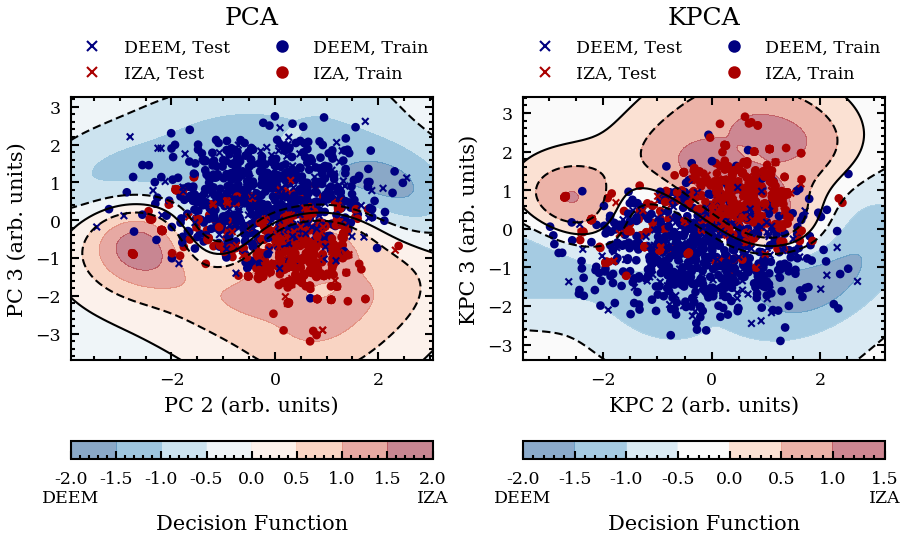

In [164]:
# Plot SVM

# Create figure and axes
fig = plt.figure(figsize=(7.0, 3.5))
axs_PCA = fig.add_subplot(1, 2, 1)
axs_KPCA = fig.add_subplot(1, 2, 2)

# Assign colors for scatter points
colors_train_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_PCA]
colors_test_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_PCA]

colors_train_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_KPCA]
colors_test_KPCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_KPCA]

# Determine bounds for PCA decision function contour
PCA_min_x = np.amin(np.concatenate((PCA_train, PCA_test))[:, 0+1])
PCA_min_y = np.amin(np.concatenate((PCA_train, PCA_test))[:, 1+1])
PCA_max_x = np.amax(np.concatenate((PCA_train, PCA_test))[:, 0+1])
PCA_max_y = np.amax(np.concatenate((PCA_train, PCA_test))[:, 1+1])

# Build grid for PCA decision function
PCA_xx, PCA_yy = np.meshgrid(np.linspace(PCA_min_x-0.5, PCA_max_x+0.5, 100),
                             np.linspace(PCA_min_y-0.5, PCA_max_y+0.5, 100))

# Compute PCA decision function
df_PCA = svc_PCA.decision_function(np.column_stack((PCA_xx.ravel(), PCA_yy.ravel())))
df_PCA = np.reshape(df_PCA, PCA_xx.shape)

# Determine bounds for KCPA decision function contour
KPCA_min_x = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 0+1])
KPCA_min_y = np.amin(np.concatenate((KPCA_train, KPCA_test))[:, 1+1])
KPCA_max_x = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 0+1])
KPCA_max_y = np.amax(np.concatenate((KPCA_train, KPCA_test))[:, 1+1])

# Build grid for KPCA decision function 
KPCA_xx, KPCA_yy = np.meshgrid(np.linspace(KPCA_min_x-0.5, KPCA_max_x+0.5, 100),
                               np.linspace(KPCA_min_y-0.5, KPCA_max_y+0.5, 100))

# Compute KPCA decision function
df_KPCA = svc_KPCA.decision_function(np.column_stack((KPCA_xx.ravel(), KPCA_yy.ravel())))
df_KPCA = np.reshape(df_KPCA, KPCA_xx.shape)

# Plot contours and scatter plots
contour_PCA = axs_PCA.contourf(PCA_xx, PCA_yy, df_PCA, cmap='RdBu_r', alpha=0.5)
axs_PCA.contour(PCA_xx, PCA_yy, df_PCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_PCA.scatter(PCA_train[:, 0+1], PCA_train[:, 1+1], marker='o', c=colors_train_PCA[:], s=10)
axs_PCA.scatter(PCA_test[:, 0+1], PCA_test[:, 1+1], marker='x', c=colors_test_PCA[:], s=10)

contour_KPCA = axs_KPCA.contourf(KPCA_xx, KPCA_yy, df_KPCA, cmap='RdBu_r', alpha=0.5)
axs_KPCA.contour(KPCA_xx, KPCA_yy, df_KPCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs_KPCA.scatter(KPCA_train[:, 0+1], KPCA_train[:, 1+1], marker='o', c=colors_train_KPCA[:], s=10)
axs_KPCA.scatter(KPCA_test[:, 0+1], KPCA_test[:, 1+1], marker='x', c=colors_test_KPCA[:], s=10)

# Axes labels
axs_PCA.set_xlabel('PC 2 (arb. units)')
axs_PCA.set_ylabel('PC 3 (arb. units)')

axs_KPCA.set_xlabel('KPC 2 (arb. units)')
axs_KPCA.set_ylabel('KPC 3 (arb. units)')

# Custom legend entries
xblue = mpllines.Line2D([], [], color=colorList[2], marker='x', 
                        markersize=5, linestyle='None', label='DEEM, Test')
oblue = mpllines.Line2D([], [], color=colorList[2], marker='o', 
                        markersize=5, linestyle='None', label='DEEM, Train')
xred = mpllines.Line2D([], [], color=colorList[1], marker='x',
                      markersize=5, linestyle='None', label='IZA, Test')
ored = mpllines.Line2D([], [], color=colorList[1], marker='o',
                      markersize=5, linestyle='None', label='IZA, Train')

# Custom legend
axs_PCA.legend(handles=(xblue, xred, oblue, ored), loc='lower center', 
               bbox_to_anchor=(0.5, 1.0), ncol=2)
axs_KPCA.legend(handles=(xblue, xred, oblue, ored), loc='lower center', 
               bbox_to_anchor=(0.5, 1.0), ncol=2)

# Axes titles
axs_PCA.set_title('PCA', pad=35)
axs_KPCA.set_title('KPCA', pad=35)

# Decision function colorbars with custom tick labels
cb_PCA = fig.colorbar(contour_PCA, ax=axs_PCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')
cb_KPCA = fig.colorbar(contour_KPCA, ax=axs_KPCA, orientation='horizontal', 
                      pad=0.2, label='Decision Function')

cb_PCA_ticks = ['%.1f' % i for i in cb_PCA.get_ticks()]
cb_PCA_ticks[0] = cb_PCA_ticks[0] + '\nDEEM'
cb_PCA_ticks[-1] = cb_PCA_ticks[-1] + '\nIZA'
cb_PCA.set_ticklabels(cb_PCA_ticks)

cb_KPCA_ticks = ['%.1f' % i for i in cb_KPCA.get_ticks()]
cb_KPCA_ticks[0] = cb_KPCA_ticks[0] + '\nDEEM'
cb_KPCA_ticks[-1] = cb_KPCA_ticks[-1] + '\nIZA'
cb_KPCA.set_ticklabels(cb_KPCA_ticks)

fig.subplots_adjust(wspace=0.25)

fig.savefig('../Results/DEEM_1k/svm_OPT_IZAonDEEM_6.0.png', bbox_inches='tight')

plt.show()